In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
import cv2
from PIL import Image
import keras
# For one-hot-encoding
from keras.utils import np_utils
# For creating sequenttial model
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
# For saving and loading models
from keras.models import load_model


import random

In [7]:
# Simple EDA

In [8]:
classes = os.listdir('/kaggle/input/vehicle/train/train')
BASE = '/kaggle/input/vehicle/train/train/'

# create dict of list of images per class
dataset = {}
for vehicle in classes:
    dataset[vehicle] = [i for i in os.listdir(BASE + vehicle)]

In [9]:
# verify
print(dataset.keys())
print(len(dataset.keys()))

dict_keys(['Taxi', 'Bicycle', 'Snowmobile', 'Tank', 'Bus', 'Motorcycle', 'Car', 'Segway', 'Helicopter', 'Truck', 'Limousine', 'Boat', 'Cart', 'Van', 'Caterpillar', 'Ambulance', 'Barge'])
17


- There are total 17 classes of vehicles

In [10]:
# convert dict to pandas df
df = pd.DataFrame.from_dict(dataset, orient='index')
df = df.transpose()

In [11]:
# train set
df.head()

Taxi        Bicycle     Snowmobile           Tank            Bus  \
0  004685_10.jpg  003652_10.jpg  000119_11.jpg  001082_18.jpg  003715_01.jpg   
1  002622_05.jpg  002482_02.jpg  001122_03.jpg  000182_07.jpg  000287_05.jpg   
2  003472_18.jpg  001204_18.jpg  000824_06.jpg  000893_18.jpg  004584_10.jpg   
3  000450_01.jpg  000417_06.jpg  004892_09.jpg  000616_00.jpg  000190_01.jpg   
4  000014_16.jpg  005260_18.jpg  002688_00.jpg  000040_06.jpg  002203_04.jpg   

      Motorcycle            Car         Segway     Helicopter          Truck  \
0  004052_10.jpg  000566_09.jpg  000204_10.jpg  003168_09.jpg  000922_03.jpg   
1  004681_00.jpg  000347_06.jpg  001865_03.jpg  001882_18.jpg  002846_10.jpg   
2  005386_18.jpg  003927_02.jpg  000757_09.jpg  000182_10.jpg  000938_04.jpg   
3  000498_07.jpg  003148_17.jpg  000366_19.jpg  004348_02.jpg  005126_05.jpg   
4  004051_05.jpg  001272_10.jpg  003355_04.jpg  000010_12.jpg  003755_05.jpg   

       Limousine           Boat           Cart            Van    Caterpillar  \
0  002501_04.jpg  004820_10.jpg  003457_18.jpg  003483_05.jpg  002045_18.jpg   
1  001009_02.jpg  003244_18.jpg  000327_16.jpg  000845_09.jpg  000431_05.jpg   
2  001171_05.jpg  000570_02.jpg  001239_03.jpg  004951_18.jpg  004663_18.jpg   
3  004703_10.jpg  002583_05.jpg  001993_00.jpg  000276_11.jpg  002467_01.jpg   
4  003303_00.jpg  004082_02.jpg  000854_19.jpg  002511_01.jpg  001095_00.jpg   

       Ambulance          Barge  
0  003507_17.jpg  000393_01.jpg  
1  003320_04.jpg  001762_01.jpg  
2  002199_00.jpg  000195_18.jpg  
3  000713_18.jpg  001068_05.jpg  
4  000050_10.jpg  000753_08.jpg

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8695 entries, 0 to 8694
Data columns (total 17 columns):
Taxi           748 non-null object
Bicycle        1618 non-null object
Snowmobile     123 non-null object
Tank           206 non-null object
Bus            2133 non-null object
Motorcycle     2986 non-null object
Car            6781 non-null object
Segway         153 non-null object
Helicopter     668 non-null object
Truck          2033 non-null object
Limousine      74 non-null object
Boat           8695 non-null object
Cart           51 non-null object
Van            1111 non-null object
Caterpillar    331 non-null object
Ambulance      132 non-null object
Barge          202 non-null object
dtypes: object(17)
memory usage: 1.1+ MB


- Dataset is imbalanced, let's visualize

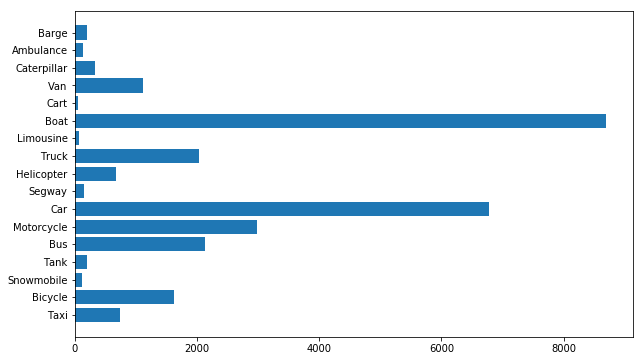

In [13]:
cols = []
col_imgs = []
for col in df.columns:
    cols.append(col)
    col_imgs.append(df[col].count())

plt.figure(figsize=(10,6))
plt.barh(cols, col_imgs)
plt.show()

- Maybe we will have to augment data

Displaying 4 ranndom image per vehicle class


<Figure size 432x288 with 0 Axes>

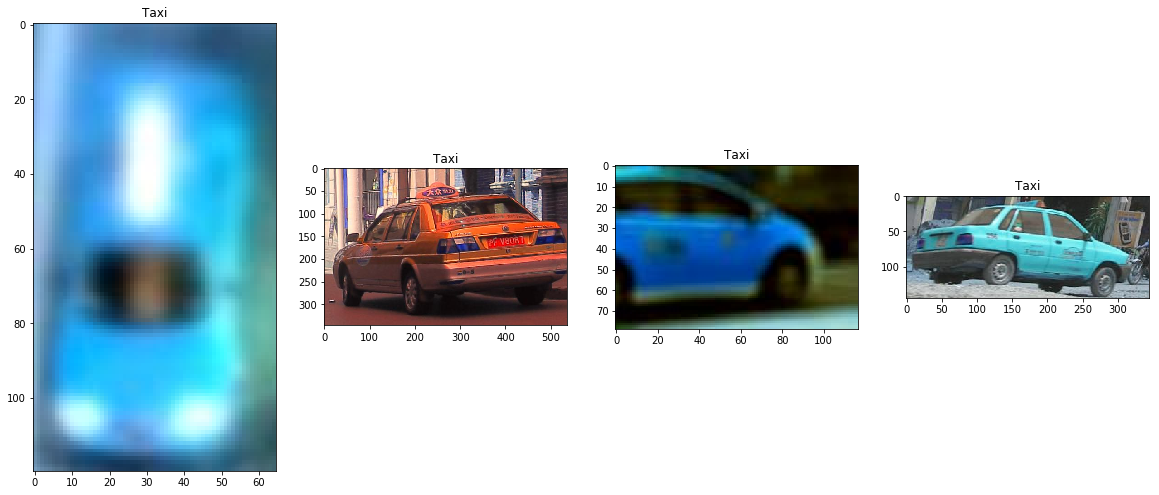

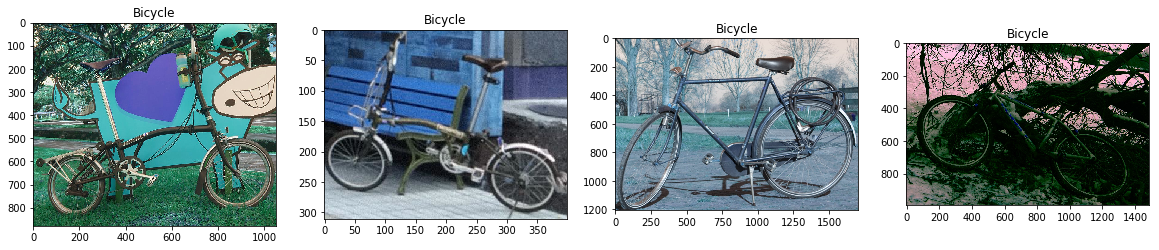

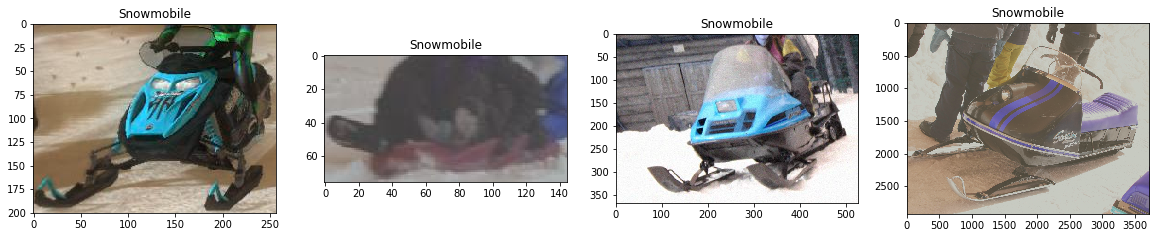

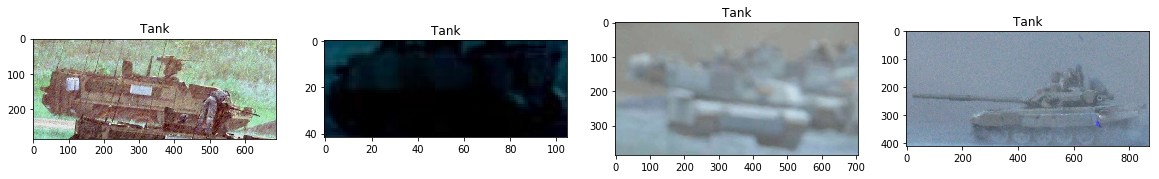

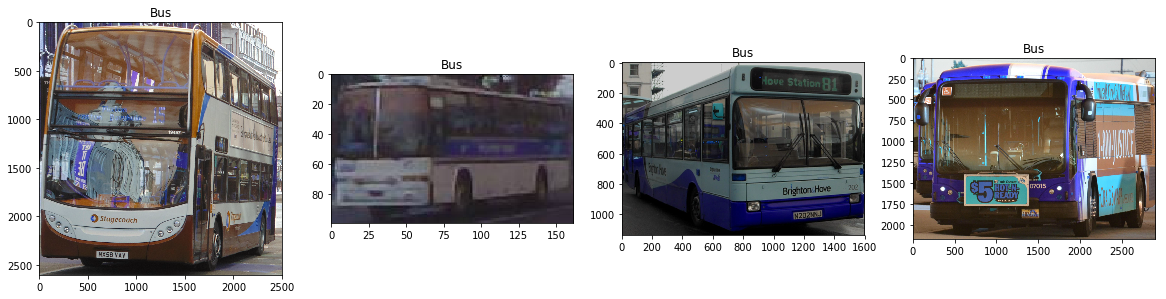

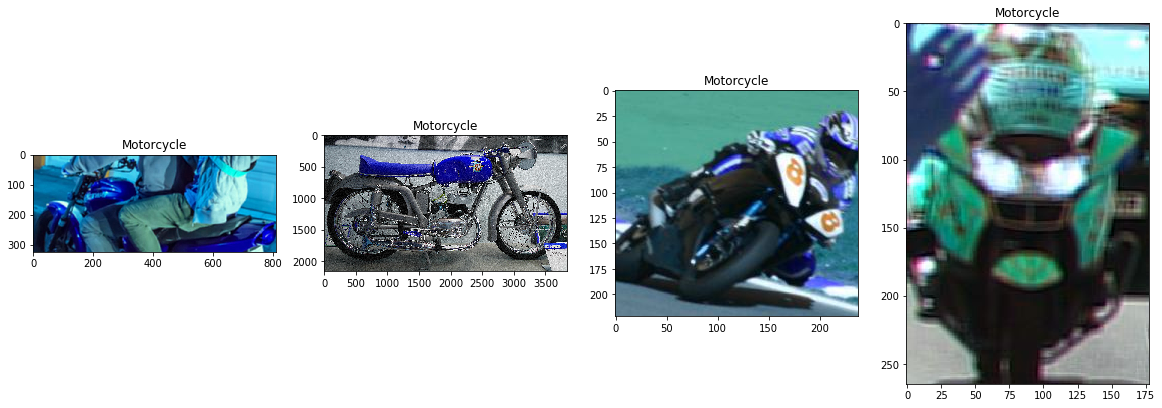

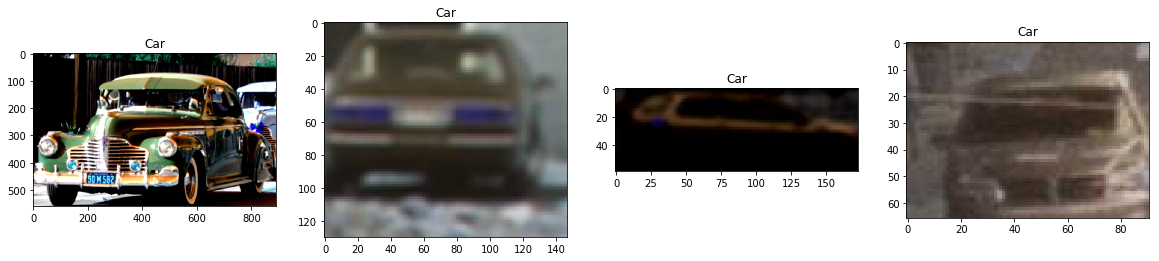

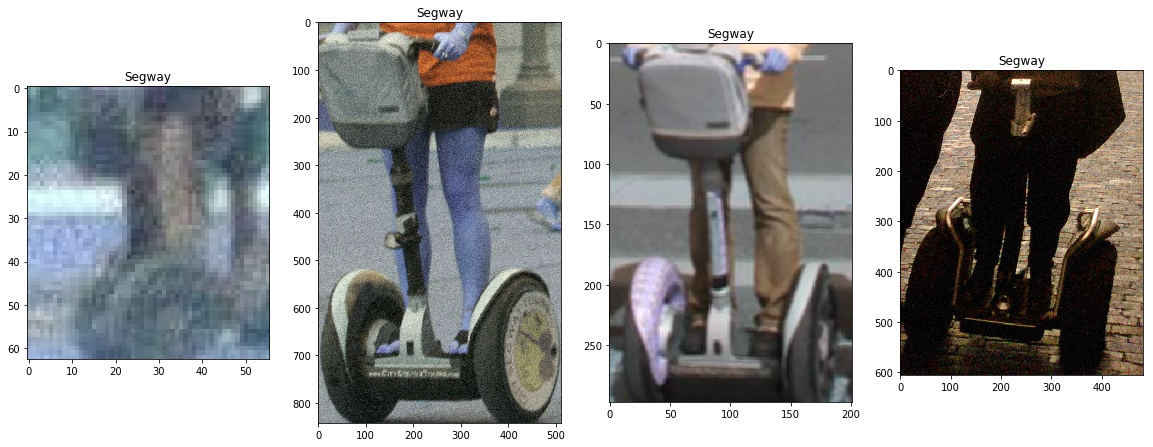

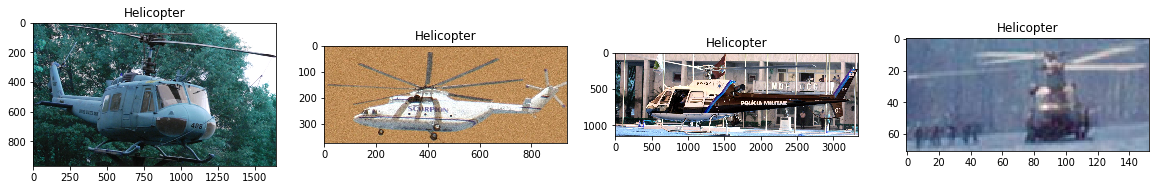

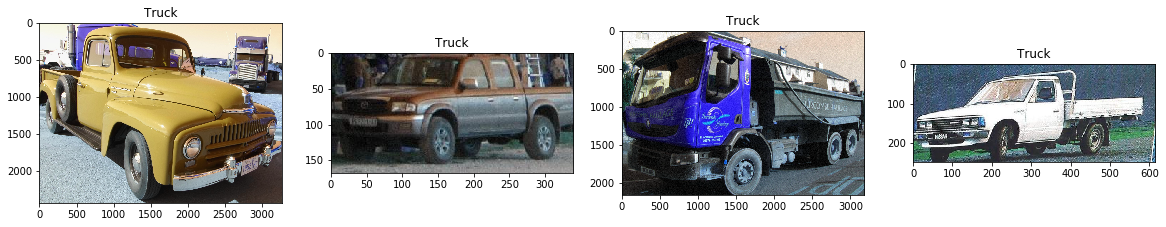

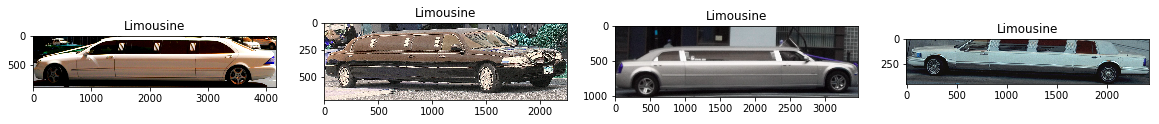

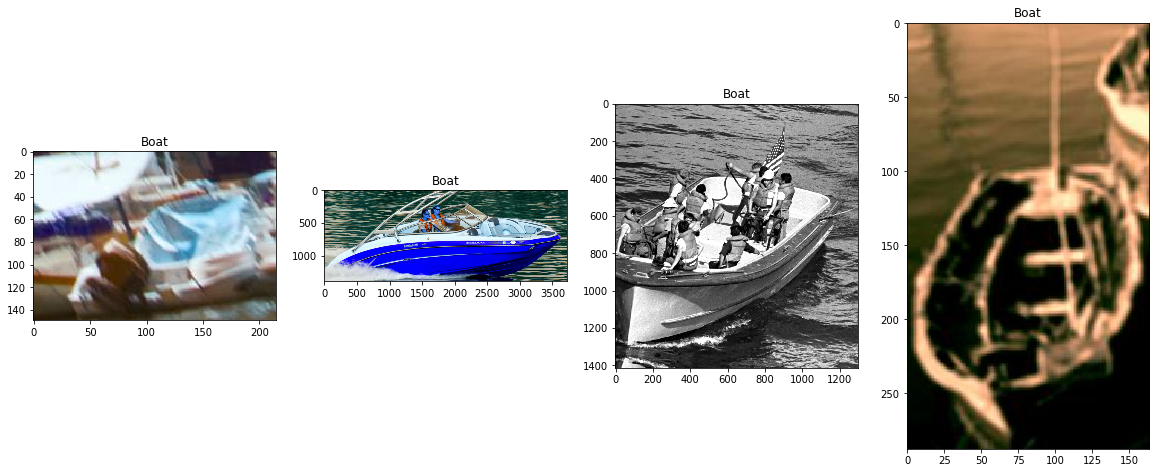

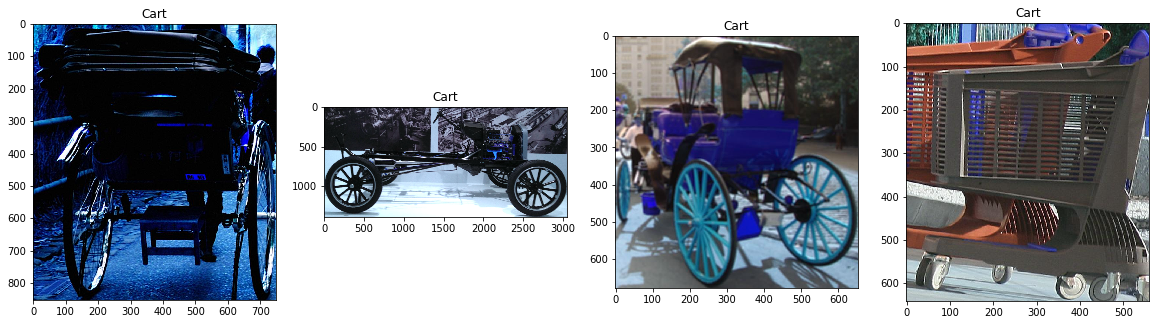

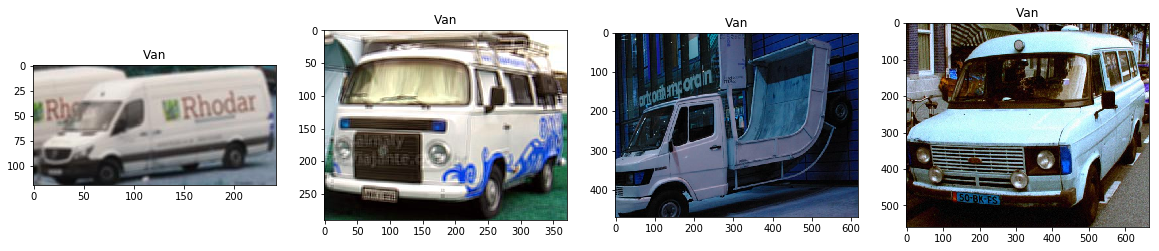

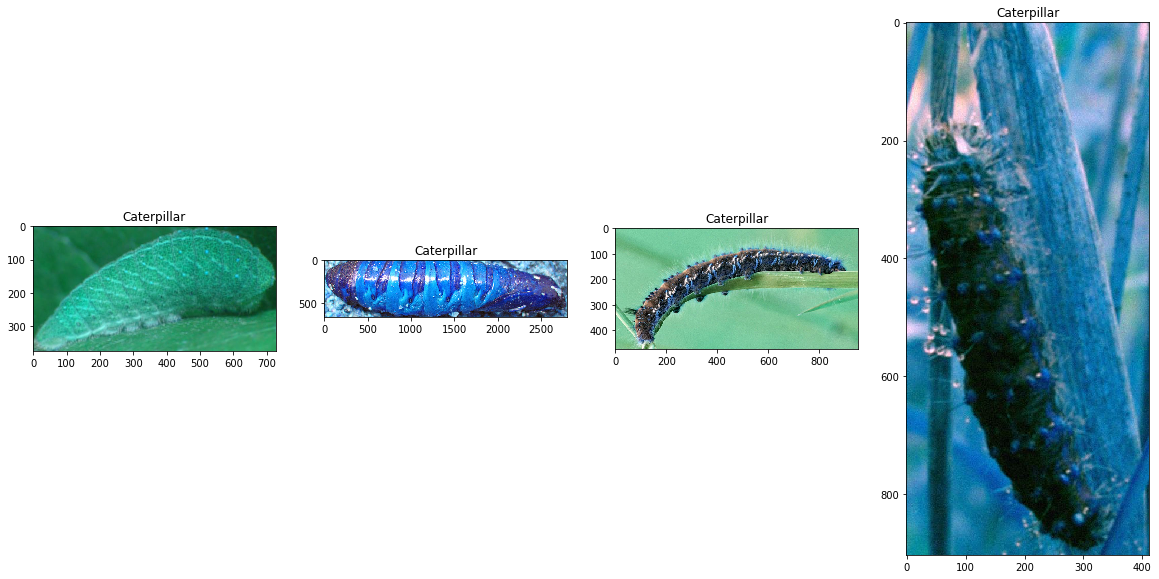

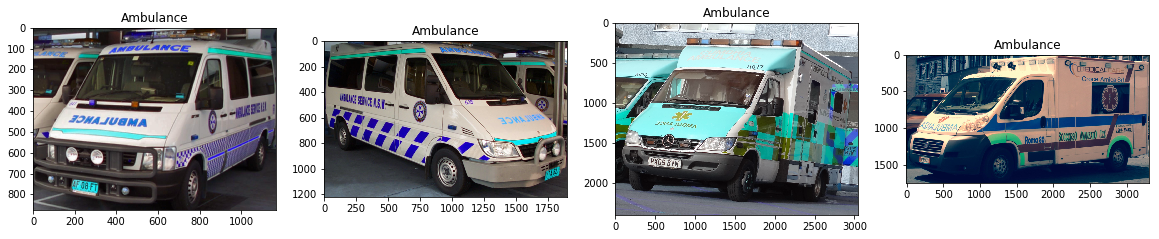

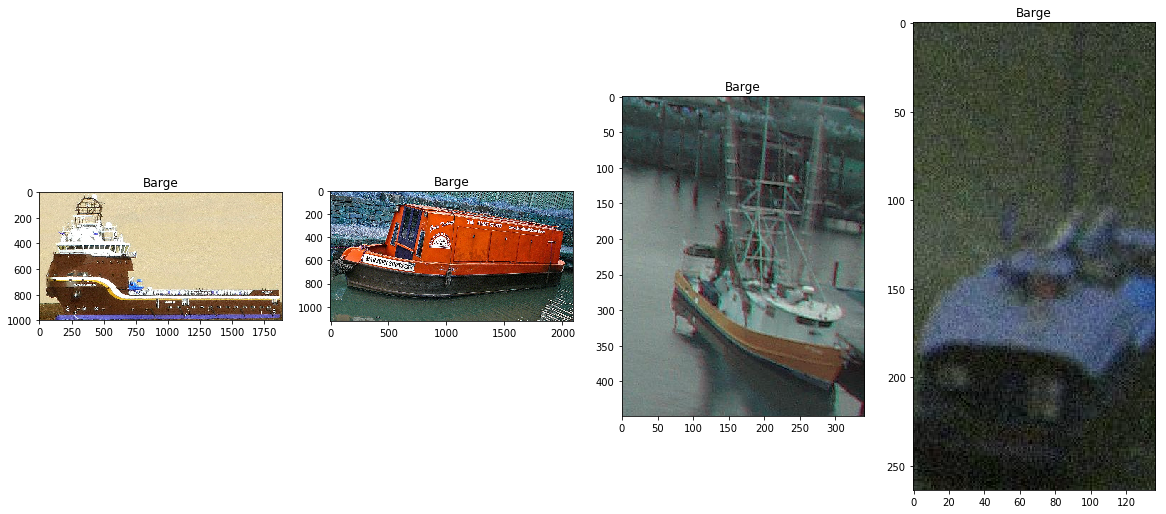

In [14]:
print("="*70)
print("Displaying 4 ranndom image per vehicle class")
print("="*70)

# for every class in `cols`
for j in range(17):
    plt.figure(j)
    plt.figure(figsize=(20,20))
    
    # 4 images per every class
    for i in range(4):
        id = "14{}".format(i+1)
        plt.subplot(int(id))
        random_file = random.choice(os.listdir(BASE + cols[j] + "/"))
        img = cv2.imread(BASE + cols[j] + "/" + random_file)
        plt.title(cols[j])
        plt.imshow(img)
plt.show()

- It is kind of funny that `Caterpillar` class has real caterpillars instead of *Caterpillar* vehicles 

## Prepare Data For Training

In [15]:
data = []
labels = []

In [16]:
'''
cols = sorted(cols)

# Creating trainable 224x224 images
#                    -------
for vehicle_class in cols:
    print(vehicle_class + " started .....")
    for filename in df[vehicle_class]:
        try:
            # for empty cols
            if filename == None:
                pass
            else:
                image = cv2.imread("/kaggle/input/vehicle/train/train/{}/".format(vehicle_class) + filename)
                image_from_numpy_array = Image.fromarray(image, "RGB")
                resized_image = image_from_numpy_array.resize((224, 224))
                data.append(np.array(resized_image))

                if vehicle_class == 'Ambulance':
                    labels.append(0)
                elif vehicle_class == 'Barge':
                    labels.append(1)
                elif vehicle_class == 'Bicycle':
                    labels.append(2)
                elif vehicle_class == 'Boat':
                    labels.append(3)
                elif vehicle_class == 'Bus':
                    labels.append(4)
                elif vehicle_class == 'Car':
                    labels.append(5)
                elif vehicle_class == 'Cart':
                    labels.append(6)
                elif vehicle_class == 'Caterpillar':
                    labels.append(7)
                elif vehicle_class == 'Helicopter':
                    labels.append(8)
                elif vehicle_class == 'Limousine':
                    labels.append(9)
                elif vehicle_class == 'Motorcycle':
                    labels.append(10)
                elif vehicle_class == 'Segway':
                    labels.append(11)
                elif vehicle_class == 'Snowmobile':
                    labels.append(12)
                elif vehicle_class == 'Tank':
                    labels.append(13)
                elif vehicle_class == 'Taxi':
                    labels.append(14)
                elif vehicle_class == 'Truck':
                    labels.append(15)
                elif vehicle_class == 'Van':
                    labels.append(16)
                else:
                    print("Something is wrong.")
                
        except AttributeError:
            print("Attribute error occured for "+filename)
'''

'\ncols = sorted(cols)\n\n# Creating trainable 224x224 images\n#                    -------\nfor vehicle_class in cols:\n    print(vehicle_class + " started .....")\n    for filename in df[vehicle_class]:\n        try:\n            # for empty cols\n            if filename == None:\n                pass\n            else:\n                image = cv2.imread("/kaggle/input/vehicle/train/train/{}/".format(vehicle_class) + filename)\n                image_from_numpy_array = Image.fromarray(image, "RGB")\n                resized_image = image_from_numpy_array.resize((224, 224))\n                data.append(np.array(resized_image))\n\n                if vehicle_class == \'Ambulance\':\n                    labels.append(0)\n                elif vehicle_class == \'Barge\':\n                    labels.append(1)\n                elif vehicle_class == \'Bicycle\':\n                    labels.append(2)\n                elif vehicle_class == \'Boat\':\n                    labels.append(3)\n       

In [17]:
'''
vehicle_images_224x224 = np.array(data)
labels_224x224 = np.array(labels)

# save
np.save("all-vehicle-224x224-images-as-arrays", vehicle_images_224x224)
np.save("corresponding-labels-for-all-224x224-images", labels_224x224)
'''

'\nvehicle_images_224x224 = np.array(data)\nlabels_224x224 = np.array(labels)\n\n# save\nnp.save("all-vehicle-224x224-images-as-arrays", vehicle_images_224x224)\nnp.save("corresponding-labels-for-all-224x224-images", labels_224x224)\n'

In [18]:
#data = np.load("all-vehicle-224x224-images-as-arrays.npy")
#labels = np.load("corresponding-labels-for-all-224x224-images.npy")

In [19]:
'''
print(vehicle_images_224x224.shape)
print(labels_224x224.shape)
print(np.unique(labels_224x224))
'''

'\nprint(vehicle_images_224x224.shape)\nprint(labels_224x224.shape)\nprint(np.unique(labels_224x224))\n'

------

In [20]:
!rm -r /kaggle/working/data

rm: cannot remove '/kaggle/working/data': No such file or directory


In [21]:
# Move images to `test` and `train` dir
import shutil
import os

os.mkdir("/kaggle/working/data")
os.mkdir("/kaggle/working/data/test")
os.mkdir("/kaggle/working/data/train")

classes = ['Bicycle', 'Boat', 'Bus', 'Car', 'Motorcycle', 'Truck', 'Van']

for dir in ["test", "train"]:
    for _class in classes:
        os.mkdir("/kaggle/working/data/{}/{}".format(dir, _class))

for _class in classes:
    images = os.listdir("/kaggle/input/vehicle/train/train/{}".format(_class))

    test = images[:300]
    
    # downsample to 1.5k images
    if len(images) < 1500:
      train = images[300:]
    else:
      train = images[300:1500]

    # move images to test-set folder
    for image in test:
        shutil.copy("/kaggle/input/vehicle/train/train/{}/{}".format(_class, image), "/kaggle/working/data/test/{}/{}".format(_class, image))

    # move images to train-set folder
    for image in train:
        shutil.copy("/kaggle/input/vehicle/train/train/{}/{}".format(_class, image), "/kaggle/working/data/train/{}/{}".format(_class, image))

In [22]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [23]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [24]:
input_path = "/kaggle/working/data/"

In [25]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    input_path + 'train',
    batch_size=32,
    #class_mode='binary',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    input_path + 'test',
    shuffle=False,
    #class_mode='binary',
    target_size=(224,224))

Found 8011 images belonging to 7 classes.
Found 2100 images belonging to 7 classes.


In [36]:
conv_base = ResNet50(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [37]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(7, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [39]:
optimizer = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [40]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=347 // 32,  # added in Kaggle
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=10  # added in Kaggle
                             )

Epoch 1/30
10/10 [==============================] - 22s 2s/step - loss: 1.6414 - accuracy: 0.4094 - val_loss: 0.3412 - val_accuracy: 0.8938
Epoch 2/30
10/10 [==============================] - 12s 1s/step - loss: 0.9057 - accuracy: 0.6656 - val_loss: 0.4451 - val_accuracy: 0.7719
Epoch 3/30
10/10 [==============================] - 17s 2s/step - loss: 0.7734 - accuracy: 0.7224 - val_loss: 2.4557 - val_accuracy: 0.8219
Epoch 4/30
10/10 [==============================] - 19s 2s/step - loss: 0.6671 - accuracy: 0.7344 - val_loss: 1.9470 - val_accuracy: 0.3562
Epoch 5/30
10/10 [==============================] - 17s 2s/step - loss: 0.6054 - accuracy: 0.7656 - val_loss: 0.1346 - val_accuracy: 0.8219
Epoch 6/30
10/10 [==============================] - 18s 2s/step - loss: 0.8157 - accuracy: 0.7094 - val_loss: 2.0725 - val_accuracy: 0.7500
Epoch 7/30
10/10 [==============================] - 18s 2s/step - loss: 0.8227 - accuracy: 0.6781 - val_loss: 1.4786 - val_accuracy: 0.7987
Epoch 8/30
10/10 [==

In [41]:
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
____________________________________________________________________________________________

In [42]:
model.save('./model')

TypeError: save() missing 1 required positional argument: 'filepath'